In [1]:
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

sys.path.append('../')
from libs import gif
from libs.datasets import MNIST
from libs.utils import montage
from tensorflow.python.framework.ops import reset_default_graph

%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use('ggplot')

In [2]:
!ls ../1_intro_to_tensorflow/libs/

ls: ../1_intro_to_tensorflow/libs/: No such file or directory


In [3]:
!cat ../info.txt

https://github.com/pkmital/CADL


## Basic Autoencoder

In [4]:
ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
ds.X.shape # 70k images, each 28 x 28

(70000, 784)

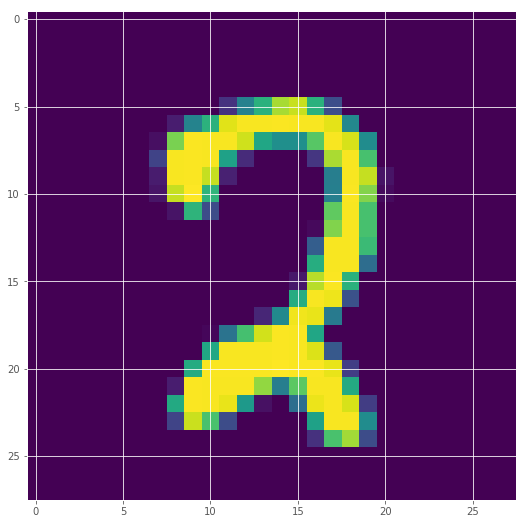

In [6]:
# show 1
plt.imshow(ds.X[40].reshape([28, 28]));

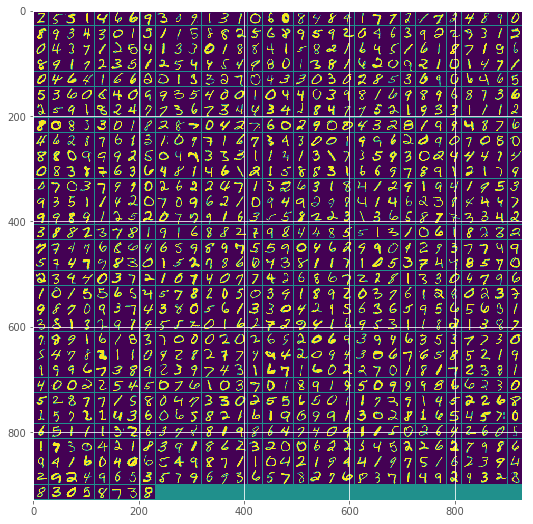

In [7]:
imgs = ds.X[:1000].reshape([-1, 28, 28])
plt.imshow(montage(imgs));

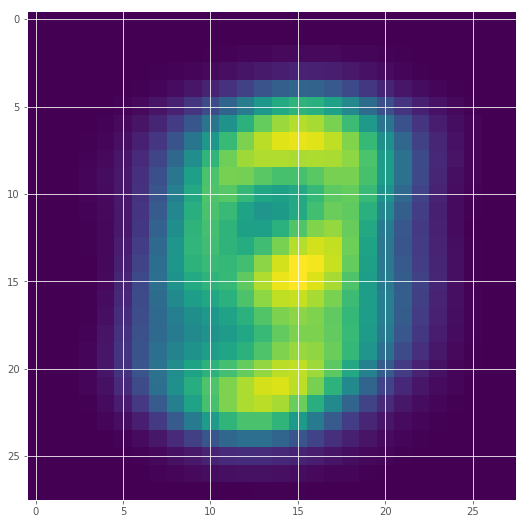

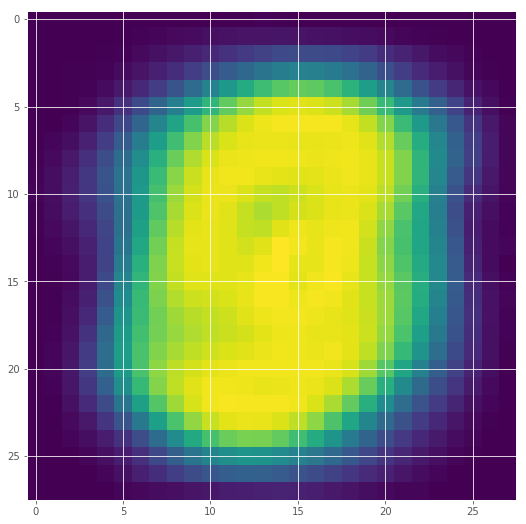

In [19]:
mean_img = np.mean(ds.X, axis=0)
sd_img = np.std(ds.X, axis=0)
plt.imshow(mean_img.reshape([28, 28]));
plt.figure();
plt.imshow(sd_img.reshape([28, 28]));

In [7]:
# network layer sizes:
dimensions = [512, 256, 128, 64]
n_features = ds.X.shape[1]

In [10]:
X = tf.placeholder(tf.float32, [None, n_features])

In [11]:
current_input = X
n_input = n_features
Ws = []

In [12]:
# Encoder
for layer, n_output in enumerate(dimensions):
    with tf.variable_scope('encoder/layer/{}'.format(layer)):
        W = tf.get_variable(
            name='W', 
            shape=[n_input, n_output], 
            initializer=tf.random_normal_initializer(mean=0., stddev=0.02))
        h = tf.matmul(current_input, W)
        # Can also add bias here
        current_input = tf.nn.relu(h)
        Ws.append(W)
        n_input = n_output

In [13]:
# Decoder prep
# Reverse order of weight matrices
Ws = Ws[::-1]
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]
dimensions

[128, 256, 512, 784]

In [14]:
# Decoder
for layer, n_output in enumerate(dimensions):
    with tf.variable_scope('decoder/layer/{}'.format(layer)):
        W = tf.transpose(Ws[layer])
        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        n_input = n_output

In [15]:
Y = current_input

In [16]:
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())
cost = tf.reduce_mean(cost)

(?,)


In [17]:
eta = 0.001
optimizer = tf.train.AdamOptimizer(eta).minimize(cost)

0 0.0429847
1 0.037203
2 0.0338809
3 0.0327041
4 0.032388
5 0.0303899
6 0.0288839
7 0.0288828
8 0.0287588
9 0.028666
10 0.0282139
11 0.028037
12 0.0282153
13 0.0270843
14 0.0269719
15 0.0276643
16 0.026501
17 0.0266909
18 0.0269492
19 0.0269606
20 0.0269738
21 0.0252307
22 0.0270676
23 0.0267641
24 0.0257301
25 0.0261771
26 0.0264303
27 0.0261687
28 0.0264021
29 0.0261176
30 0.0258658
31 0.0264593
32 0.0253421
33 0.0263146
34 0.0248594
35 0.0250868
36 0.0256352
37 0.0255248
38 0.0254539
39 0.0258175
40 0.0260906
41 0.0261138
42 0.0250524
43 0.0251906
44 0.0247662
45 0.025594
46 0.0246325
47 0.0258688
48 0.0261448
49 0.0251119
50 0.0252944
51 0.0256782
52 0.0264636
53 0.0255159
54 0.0255362
55 0.0253028
56 0.024593
57 0.0260128
58 0.0245072
59 0.0249072
60 0.0249912
61 0.0255722
62 0.0251299
63 0.0245269
64 0.025104
65 0.0256877
66 0.0248484
67 0.0255638
68 0.0251531
69 0.0249554
70 0.0246961
71 0.0242881
72 0.0244993
73 0.0242587
74 0.0243152
75 0.0255882
76 0.0240506
77 0.0247025
78 0

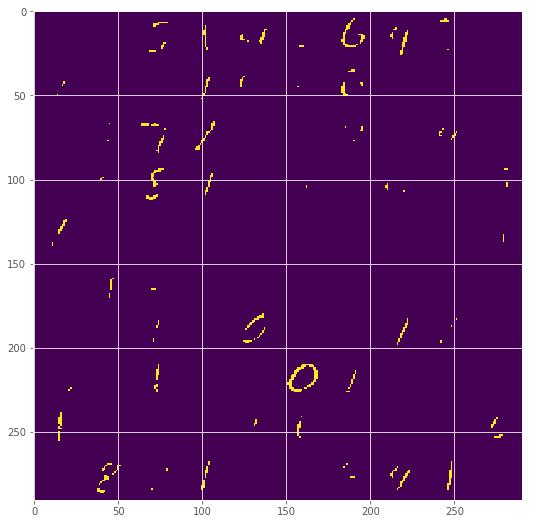

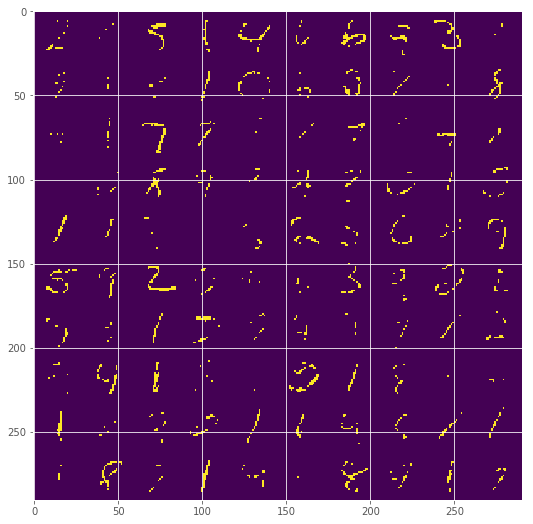

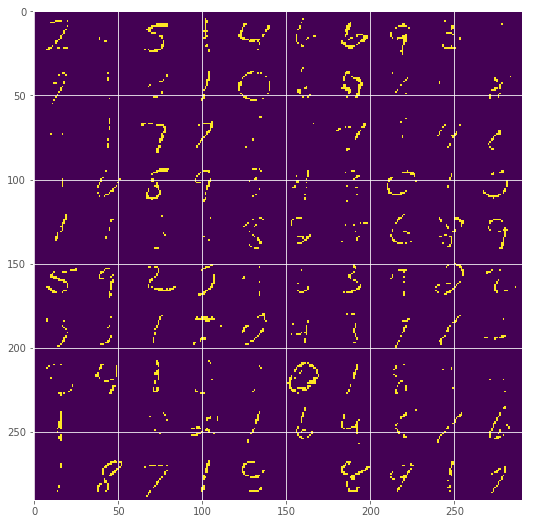

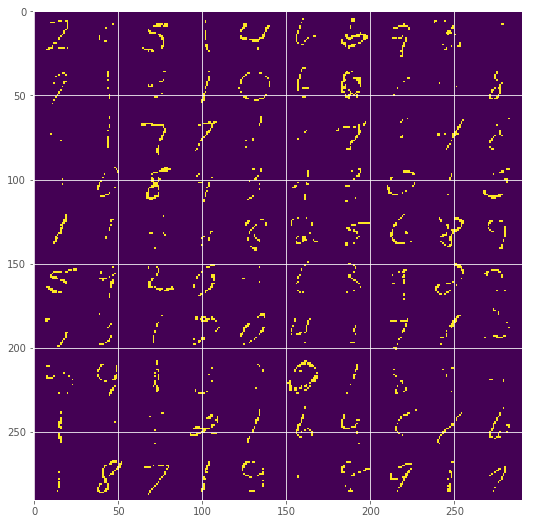

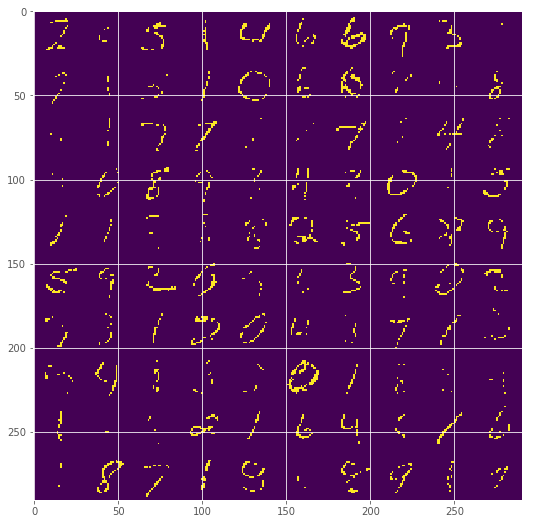

In [18]:
s = tf.Session()
s.run(tf.global_variables_initializer())
batch_size = 100
n_epochs = 100
examples = ds.X[:100]
imgs = []

for epoch in range(n_epochs):
    for batch, _ in ds.train.next_batch():
        s.run(optimizer, feed_dict={ X: batch - mean_img })
    if epoch % 20 == 0:
        recon = s.run(Y, feed_dict={ X: examples - mean_img })
        recon = np.clip((recon + mean_img).reshape([-1, 28, 28]), 0, 255)
        img = montage(recon).astype(np.uint8)
        imgs.append(img)
        plt.figure();
        plt.imshow(img);
    print(epoch, s.run(cost, feed_dict={ X: batch - mean_img }))
    
# gif.build_gif(imgs, saveto='ae.gif', cmap='gray')
    
s.close()

## Convolutional Autoencoder

In [2]:
reset_default_graph() #RERUN FROM HERE-- Check agst master

In [8]:
X = tf.placeholder(tf.float32, [None, n_features])
X_tensor = tf.reshape(X, [-1, 28, 28, 1])
n_filters = [16, 16, 16]
filter_sizes = [4, 4, 4] # 4 x 4 for each layer

In [9]:
current_input = X_tensor
n_input = 1
Ws = []
shapes = []

In [10]:
for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope("encode/layer/{}".format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        
        # Create weight matrix which will increasingly reduce the amount
        # of info in the input in the input by matrix multiplication
        W = tf.get_variable(
            name='W', 
            shape=[filter_sizes[layer_i], 
                   filter_sizes[layer_i],
                   n_input,
                   n_output],
            initializer=tf.random_normal_initializer(mean=0., stddev=0.02))
        
        # Convolve input by new W
        h = tf.nn.conv2d(
            current_input, W, strides=[1, 2, 2, 1], padding='SAME')
        current_input = tf.nn.relu(h)
        
        # Store for decoder
        Ws.append(W)
        
        # Update outputs as new inputs
        n_input = n_output

In [11]:
# Reverse the process for decoding
Ws.reverse()
shapes.reverse()
n_filters.reverse()
n_filters = n_filters[1:] + [1] # greyscale image
print(n_filters, filter_sizes, shapes)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [12]:
# Loop through convolution filters and get back our input image
for layer_i, shape in enumerate(shapes):
    with tf.variable_scope('decoder/layer/{}'.format(layer_i)):
        W = Ws[layer_i]
        
        # In reverse, convolve by transpose of previous convolution tensor
        h = tf.nn.conv2d_transpose(
            current_input, 
            W,
            tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1],
            padding='SAME')
        
        current_input = tf.nn.relu(h)

In [13]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

In [14]:
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
eta = 0.001

optimizer = tf.train.AdamOptimizer(eta).minimize(cost)

In [15]:
batch_size = 100
n_epochs = 5

In [16]:
s = tf.Session()
s.run(tf.global_variables_initializer())

In [17]:
# Try to reconstruct the first 100 images, and show
examples = ds.X[:100]

# Store reconstructions in list
imgs = []

0 0.0266284
1 0.0257704
2 0.0253571
3 0.0234368
4 0.0249322


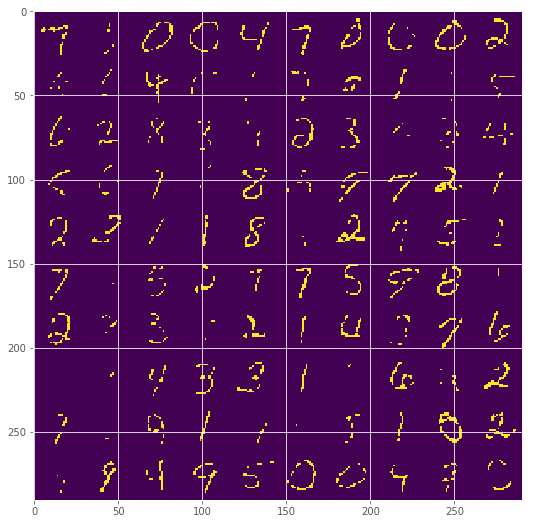

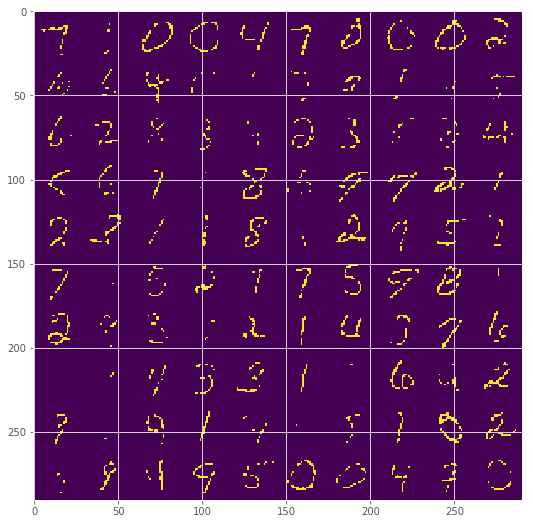

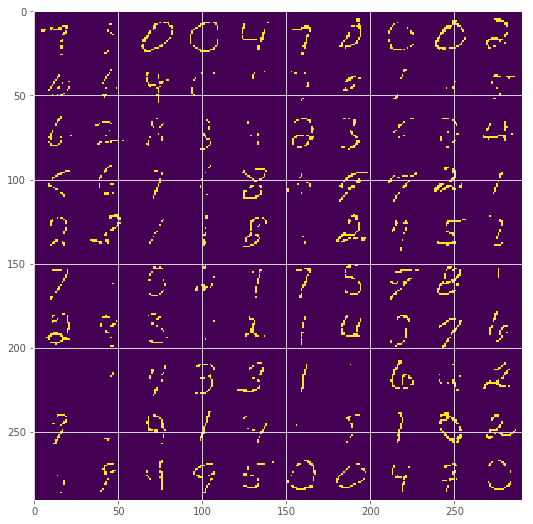

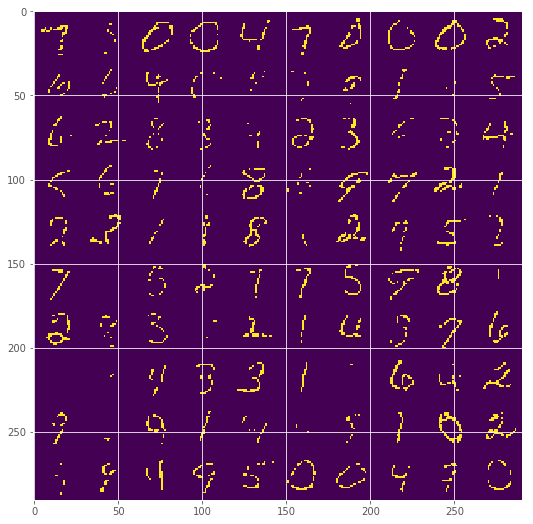

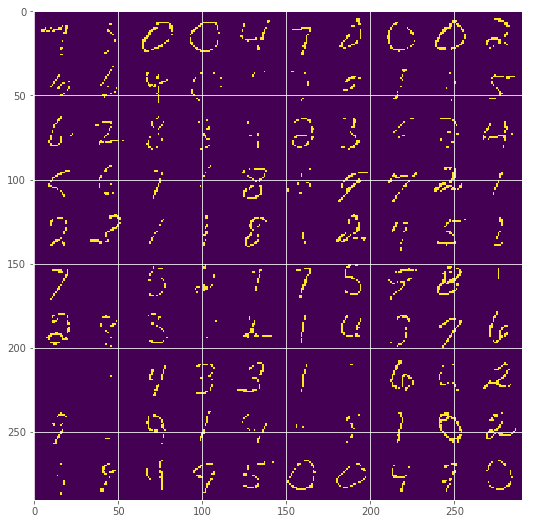

In [20]:
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        s.run(optimizer, feed_dict={X: batch_X - mean_img})
    
    recon = s.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    plt.figure();
    plt.imshow(img_i)
    print(epoch_i, s.run(cost, feed_dict={X: batch_X - mean_img}))

## Predicting Image Labels

In [6]:
ds = MNIST(one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


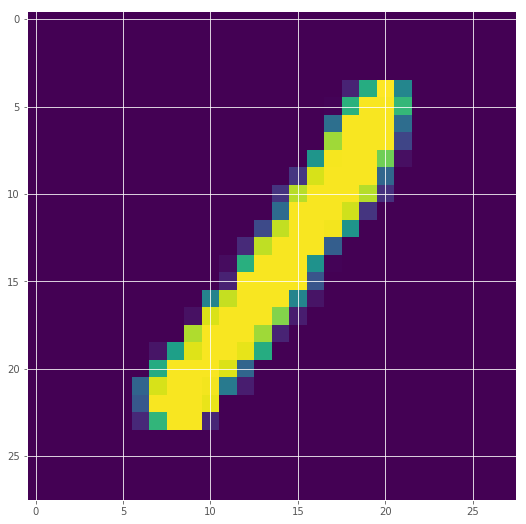

In [7]:
print(ds.Y[0])
plt.imshow(np.reshape(ds.X[0], [28, 28]));

## One-Hot Encodings